In [1]:
%matplotlib inline
import warnings

warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import mdtraj as md

In [2]:
dt_ps = 0.1
dt = dt_ps/1000

In [3]:
def get_trajectory(traj_path, top_path):
    
    traj = md.load(traj_path,top=top_path)

    com = md.compute_center_of_mass(traj)

    df = pd.DataFrame(com, columns=['x', 'y', 'z'])
    df['t'] = traj.time/1000 # Gromacs trajectories are in picoseconds - we want nanoseconds 
    
    return df

In [4]:
def get_csv_trajectory(traj_path, top_path=None):
    df = pd.read_csv(traj_path, header=None, names=['t', 'x', 'y', 'z'])
    return df

In [5]:
def plot_trajs(traj_path, top_path=None, stride=100):
    if traj_path.split('.')[-1] == 'csv':
        df = get_csv_trajectory(traj_path)
    else:
        df = get_trajectory(traj_path, top_path)
        
    df = df.iloc[::stride, :]
    root_name = traj_path.split('/')[-1].split('.')[0]

    coor_melt = pd.melt(df, id_vars='t', var_name='coord')
    g = sns.FacetGrid(coor_melt, col='coord', sharey=False)
    g.map(plt.scatter, 't', 'value', alpha=0.5, s=1)
    g.set_axis_labels('time (ns)', 'position (nm)')
    plt.savefig('{}-xyz.png'.format(root_name))

    fig = plt.figure(figsize=(15,10))
    for i in range(6):
        ax = fig.add_subplot(2,3,i+1,projection='3d')
        ax.scatter(xs=df['x'], ys=df['y'], zs=df['z'], c=df['t'], s=5, alpha=0.5)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.view_init(azim=60*i)
    plt.tight_layout()
    plt.savefig('{}-3d.png'.format(root_name))

## Visualise frozen trajectories. 

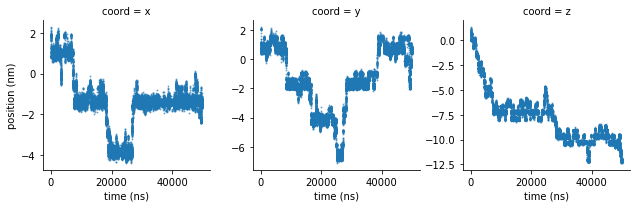

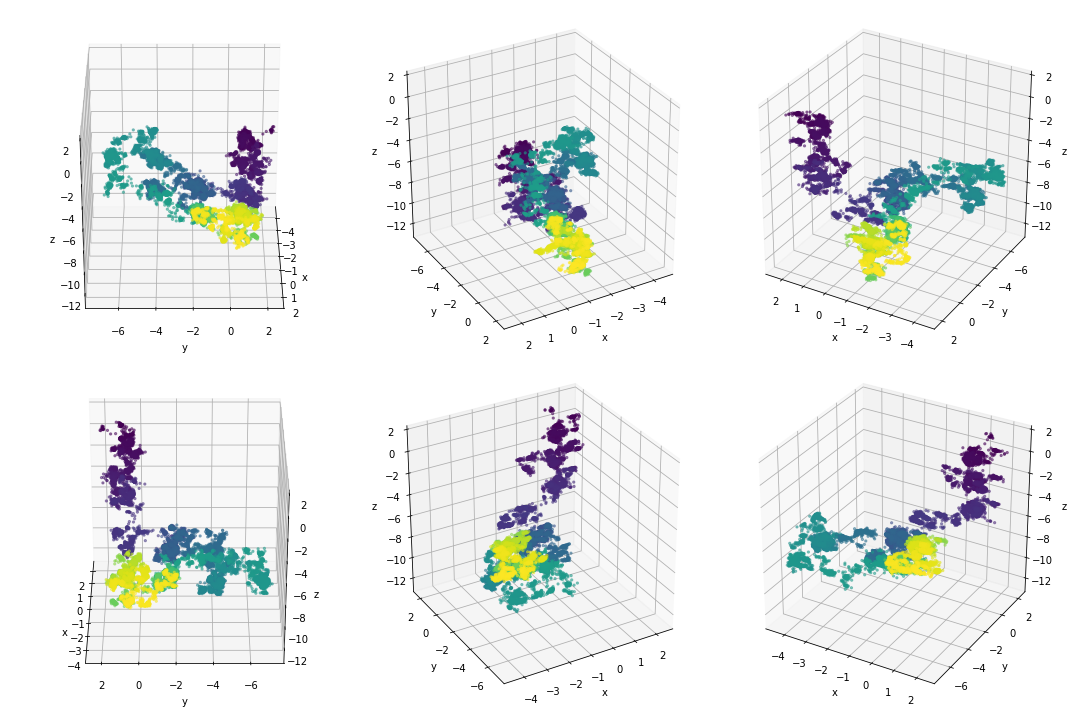

In [6]:
plot_trajs('data/4_151ns_com_positions.csv',stride=10)

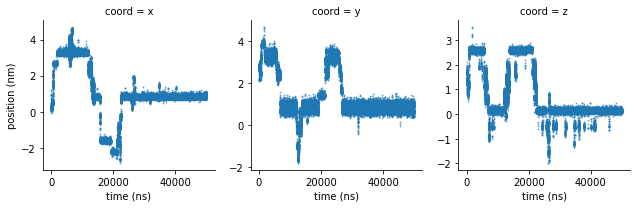

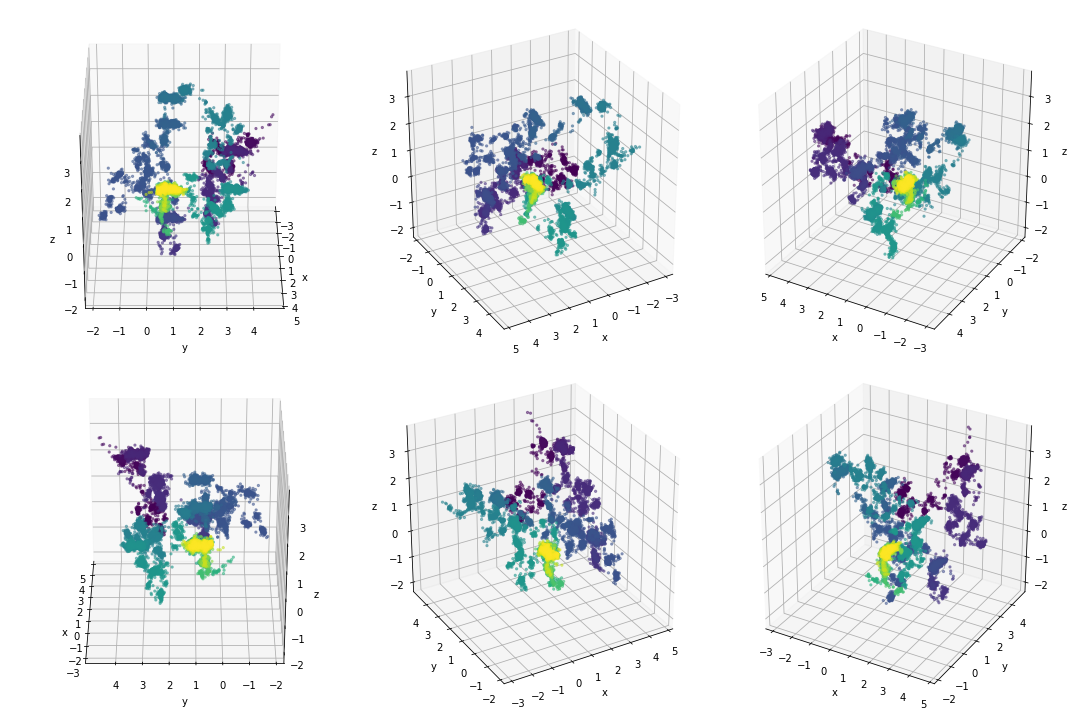

In [7]:
plot_trajs('data/4_152ns_com_positions.csv',stride=10)

## Compare frozen to unfrozen trajectories. 

In [9]:
frozen_151 = get_csv_trajectory('data/4_151ns_com_positions.csv')
frozen_152 = get_csv_trajectory('data/4_152ns_com_positions.csv')

unfrozen = get_trajectory('data/traj_4.xtc', 'data/water_top.pdb')

idx = (unfrozen['t'] < 153) & (unfrozen['t']>150)
unfrozen = unfrozen.loc[idx, :]


In [10]:
frozen_151['simulation'] = 'frozen_151'
frozen_152['simulation'] = 'frozen_152'
frozen_151['t'] /= 1000 
frozen_152['t'] /= 1000
unfrozen['simulation'] = 'unfrozen'

combined = pd.concat([frozen_151,frozen_152, unfrozen])

In [11]:
combined.head()

,simulation,t,x,y,z
0,frozen_151,0.0000,1.25630,1.99070,1.07702
1,frozen_151,0.0001,1.31668,2.04162,1.12011
2,frozen_151,0.0002,1.35380,2.07816,1.15042
3,frozen_151,0.0003,1.39639,2.09764,1.19310
4,frozen_151,0.0004,1.39499,2.11216,1.22249


## Check relative velocities

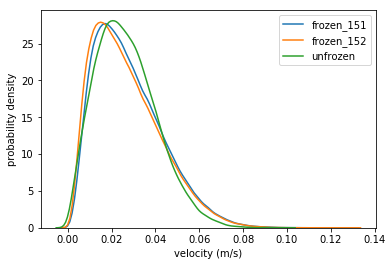

In [12]:
fig, ax = plt.subplots()
trajs = [frozen_151,frozen_152, unfrozen]
trajs_names = ['frozen_151', 'frozen_152', 'unfrozen']
for i,df in enumerate(trajs):
    vel = np.sqrt(np.sum(np.power(df.iloc[1:, 1:4].values - df.iloc[:-1, 1:4].values, 2), axis=1))
    sns.distplot(vel, hist=False, kde=True,norm_hist=True,  ax=ax,label=trajs_names[i], 
                 hist_kws={"histtype": "step", "linewidth": 3})
plt.xlabel('velocity (m/s)')
plt.ylabel('probability density')
plt.legend()
    

## Densities of positions - all times


In [47]:
comb_melt = pd.melt(frame=combined, id_vars = ['t', 'simulation'], var_name='coord')
sample = comb_melt.query('value<3').query('value >0')

No handles with labels found to put in legend.


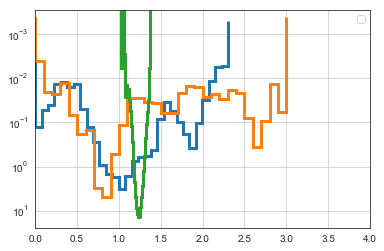

In [51]:
sns.set_style('white')
hists = sample.query('coord=="x"').groupby(['simulation', 'coord'])['value'].hist(bins=30,
                                                                                     **{'density': True, 
                                                                                        'log':True, 
                                                                                       'histtype': 'step',
                                                                                       'lw': 3})
plt.gca().invert_yaxis()
plt.xlim(0,4)
plt.legend()

(0, 4)

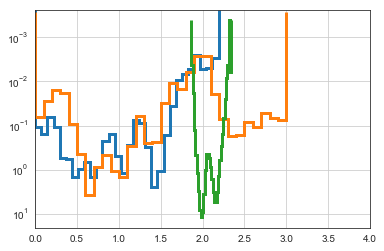

In [49]:
sns.set_style('white')
hists = sample.query('coord=="y"').groupby(['simulation', 'coord'])['value'].hist(bins=30,
                                                                                     **{'density': True, 
                                                                                        'log':True, 
                                                                                       'histtype': 'step',
                                                                                       'lw': 3})
plt.gca().invert_yaxis()
plt.xlim(0,4)

(0, 4)

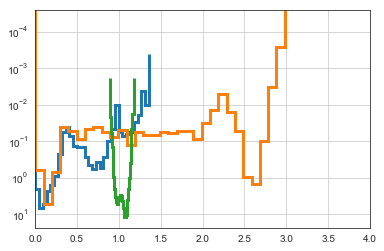

In [50]:
sns.set_style('white')
hists = sample.query('coord=="z"').groupby(['simulation', 'coord'])['value'].hist(bins=30,
                                                                                     **{'density': True, 
                                                                                        'log':True, 
                                                                                       'histtype': 'step',
                                                                                       'lw': 3})
plt.gca().invert_yaxis()
plt.xlim(0,4)

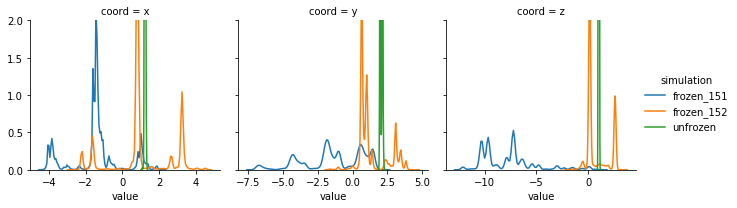

In [15]:
g = sns.FacetGrid(comb_melt, col='coord',hue='simulation',  
                  sharey='row', sharex=False, legend_out=True)
g.map(sns.distplot, 'value', hist=False, kde=True).add_legend().set( ylim=(0,2 ))
# g.set_axis_labels('time (ns)', 'position (nm)')
# plt.savefig('traj-4_frozen-unfrozen_xyz.png')

In [152]:
comb_melt.head()

,t,simulation,coord,value
0,0.0000,frozen_151,x,1.25630
1,0.0001,frozen_151,x,1.31668
2,0.0002,frozen_151,x,1.35380
3,0.0003,frozen_151,x,1.39639
4,0.0004,frozen_151,x,1.39499


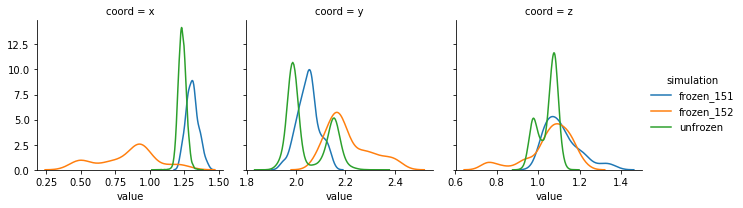

In [191]:
idx = ((comb_melt['simulation'].isin(['frozen_151', 'frozen_152'])) & (comb_melt['t'] < 100*(0.0001)) )| (comb_melt['simulation']=='unfrozen')
comb_melt.loc[idx, :].head()

g = sns.FacetGrid(comb_melt.loc[idx, :], col='coord',hue='simulation', sharey='row', sharex=False, legend_out=True)
g.map(sns.distplot, 'value', hist=False, kde=True, norm_hist=True, 
      hist_kws={"histtype": "step", "linewidth": 1, "alpha": 1}).add_legend()
